# How to generate rates of elevation change and time series from ICESat-2

ICESat-2 Hackweek 2020\
Johan Nilsson\
Jet Propulsion Laboratory\
2020-06-16

In this tutorial we will present an easy processing flow to generate gridded altimetry time series of elevation change based on the captoolkit software. We will then use these results to produce estimates mass balance for Pine Island Glacier. Its should be noted that this processing flow works equally well for other altimetry missions as well, both space- and airborne.

## Tutorial preparation (during the live event)

1. Log on to the event Jupyterhub: https://icesat-2.hackweek.io
2. Open a terminal in Jupyterlab
3. Clone repo: git clone https://github.com/ICESAT-2HackWeek/ScienceDataGeneration.git
4. Enter the directory and open the notebook

## Tutorial preparation and running (after the event)
This tutorial originally used pre-processed data that was provided to workshop participants on a shared drive which is no longer available. Thus, in order to run this tutorial notebook you will need to obtain data, run the pre-processing, and modify the paths within this notebook to point at wherever you have stored that data. An easy way to download data would be to use the [icepyx](https://icepyx.readthedocs.io/en/latest/) Python library, as demonstrated in the [data access tutorials](https://github.com/ICESAT-2HackWeek/data-access), with the data parameters described below. Then, you can use the [captoolkit](https://github.com/fspaolo/captoolkit) utilities to pre-process the data.

**Please note that this notebook will not run in Binder without download and pre-processing of large datasets and proper adjustment of paths within the notebook.**

## Introduction

In many aspects of Earth Science gridded datasets plays an important role for understanding and extracting geophysical signals in both space and time. 

So what are the reasons why we would like to work with gridded datasets?

- Understaing geophysical signals in both time and space based on noisy observations 
- Reducing data to a size that is usable for storage 
- To allow for easy analysis and visualization of large scale data sets  
- Application of advanced digital signal processing algorithms.

Satellite altimetry has for decades been used to study the worlds ice sheets and glaciers by measuring the change of elevation over time. We will here present a method to separate static topography from the time variable signal of interest. This will allow us to both create gridded datasets for time-variable elevation change and to generate DEMs bases on the static topography. 

## Learning objectives
- Get familiar with a simple altimetry processing flow to generate elevation change and time series
- Understand what the important parameters are in the flow
- Understand limitations and bottleneckz
- Tuneing of parameters obtain good results 
- Gridding and filtering off different geophysical entities

![is_dhdt.jpeg](is_dhdt.jpeg "Figure of Eleavtion Change from ICESat")
[ Image credit: Johan Nilsson (JPL) ]

## Data products and general approach

The data we will use in this excercis is the ATL06 data product, which has been flatten and sub-sampled based on the previous excercies. It contains the minumim number of variabels needed to run this example and generate sciece worthy data products. In this case we only need: **lon, lat, time and height**.

We will here show you how to make the following a simple way to make a few intresting and important science products:

- Time Sereis of Elevation Change
- Computing Rates of Elevation Change
- Constructing high-resolution DEMs
- Quality control of altimetry data

These are already standard products from the ICESat-2 mission which means you don't have to do it yourself...nice right! Big thanks to Ben Smith for putting all the hard work to make that happen! However, the processing flow presented here is generic and can be applied to any altimeter mission.

## Case study: Pine Island Glacier - Cookbook recipe
In this section we will use surface elevations from ICESat-2 from 2018/10 - 2020/04 over Pine Island Glacier (PIG) which is one the most active glaciers in Antartcica. But before we start with the excersice we need to import some packages and functions that we need for the analysis. Many of them can be found in the "utils.py" file and have been written and devloped here at JPL as part of the **captoolkit**.

In [1]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter

First, before we do anything lets have a look at the data

In [91]:
!ls ./tutorial-data/gridding-time-series/org/

IS2_HEIGHTS_PIG_A.h5 IS2_HEIGHTS_PIG_D.h5


You notice that we have two different files with the endings "A" and "D". This is due to the fact that we have separated the data into ascending and descending orbits. This was done directly using captoolkit's ATL06 reader **readatl06.py**, which is just one of many readers avalibale. The need for this will become clear very soon I hope when we start processing the data.

Let's look at the variables in the data!

In [92]:
!h5ls ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5

h_elv                    Dataset {9946174}
lat                      Dataset {9946174}
lon                      Dataset {9946174}
orbit                    Dataset {9946174}
t_year                   Dataset {9946174}


Now when we have done that let's load the ICESat-2 ATL06 elevations into memory and plot it.

In [2]:
with h5py.File('./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5','r') as f_a:
    lat   = f_a['lat'][:]
    lon   = f_a['lon'][:]
    h_elv = f_a['h_elv'][:]
    t_yrs = f_a['t_year'][:]

Let's also read in a grounded ice mask that we can use later to edit our data with.

In [3]:
with h5py.File('./tutorial-data/gridding-time-series/ANT_groundedice_1000m.h5','r') as f_m:
    Xm = f_m['X'][:]
    Ym = f_m['Y'][:]
    Zm = f_m['Z'][:]

Let's plot the data and see what we get!

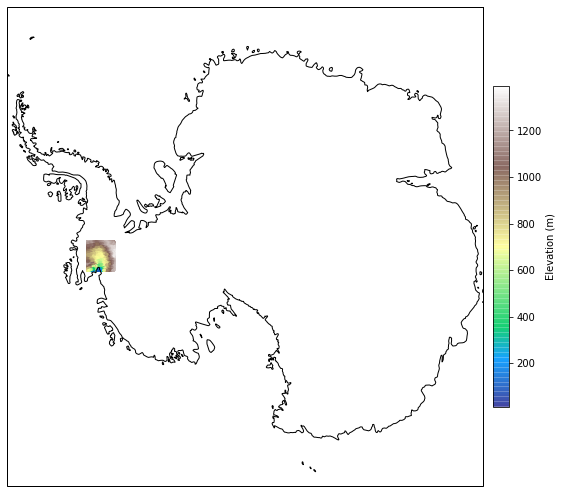

In [4]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -66], crs=ccrs.PlateCarree())
plt.scatter(lon[::100], lat[::100], s=3, c=h_elv[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

We can here see our region of interest (ROI) that we will use for the analysis. Now will zoom in so we can get more detail.

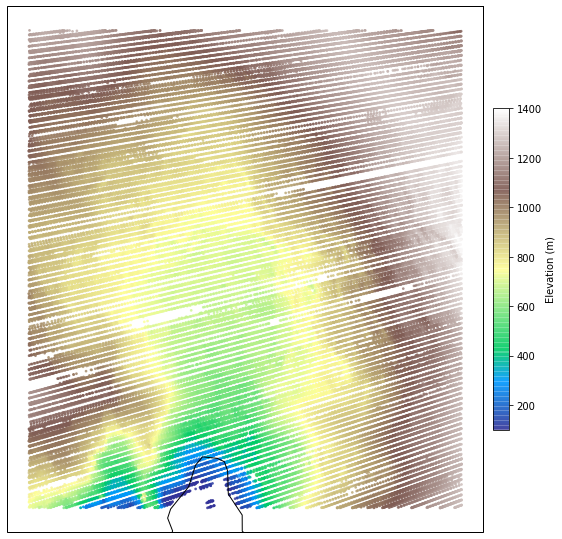

In [5]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::100], lat[::100], s=3, c=h_elv[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
plt.clim([100,1400])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

Here, you can see how data density of ICESat-2 tracks looks over Pine Island. You can for example see we have some data missing here and there due to intial filtering in the reading procedure (quality summary variable mostly). We can clearly see trunk and the catchment of PIG here just looking at the elevation. Remeber we are only plotting every 100 points so there is 100 times more data than shown here!!

In [6]:
print('Min. height:', int(h_elv.min()),'(m)', 'Max. height:', int(h_elv.max()),'(m)')

Min. height: 10 (m) Max. height: 1392 (m)


Text(0.5, 0, 'Elevation (m)')

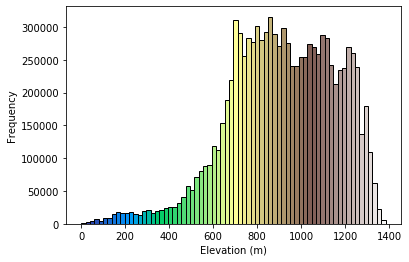

In [7]:
cm = plt.cm.get_cmap('terrain')
Y,X = np.histogram(h_elv, 70)
x_span = h_elv.max()-h_elv.min()
C = [cm(((x-X.min())/x_span)) for x in X]
plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],edgecolor='k')
plt.ylabel('Frequency')
plt.xlabel('Elevation (m)')

## captoolkit - Cryosphere Altimetry Processing Toolkit

https://github.com/fspaolo/captoolkit

This repo is a collection of command-line programs to read, process and analyze altimetry datasets. It is a consolidation of several years of work and experience in how to work with altimetry data to generate science data to understand our changing Cryosphere. 

Here, we are going to show how to use a small portion of these programs to create a simple processing workflow that will provide us the ability to go from elevation point data point to gridded data products of time series and elevation. This software is used daily for our own research and is constantly changing and hopefully improving, so please let us know if we can make any improvement or if something is not working properly.

In this excercies we are going to use four different programs avalibale in the repo:

- **fittopo.py**: Detrend surface elevation to separate time-variable elevation from static topography by removing a matehmatical surface.
- **merge.py**: simple program for merging hdf5-files and selecting variables wanted variables.
- **interpgaus3d.py**: Spatio-Temporal interpoaltion of irregular data to grid using gaussian weights.
- **readatl06.py**: reading and separation of ATL06 into induvidual beams files
- **xover.py**: program for computing satellite crossover differences 

That’s it! Those are the main program that you need to construct time series! But we have also gathered plenty of helpful functions in **utils.py** that can be imported for further data filter, gridding and analysis. We will show some of these here in the notebook and how you can use them.

Here is a summary for the functions used from **utils.py**:

- **make_grid**: construct a grid provided boundries and resolution
- **binning**: binning of data using mean or median with corresponding statistics 
- **spatial_filter**: spatial outlier filter using robust n-sigma rule and threshold 
- **transform_coord**: coordinate transformation using pyproj based on EPSG-number
- **interp2d**: point to raster interpolation based on ndimage's map_coordinates
- **interpkrig**: interpolation using ordinary kriging/collocation of irregular data in space
- **interpmed**: interpolation using median of irregular data in space
- **interpgaus**: interpolation using gaussian kernel of irregular data in space
- **tiffread**: reading of tiff-files

Here is the link to the repo if you want to download and use it later on your own personal computer

In [ ]:
#git clone https://github.com/fspaolo/captoolkit.git
#cd captoolkit
#python setup.py install

Ok ones you have installed the repo let's have a look at the first program **fittopo.py** which gives you the opportunity to separate the time-variable surface elevation form the static one:

In [8]:
!python fittopo.py -h

usage: fittopo.py [-h] [-d dx dy] [-r radius] [-q n_reloc] [-i n_iter]
                  [-z min_obs] [-m mod_lim] [-k mod_order] [-t ref_time]
                  [-j epsg_num] [-v x y t h] [-x expr] [-n n_jobs]
                  [-s slope_lim] [-p]
                  file [file ...]

Compute surface elevation residuals from satellite/airborne altimetry.

positional arguments:
  file          file(s) to process (HDF5)

optional arguments:
  -h, --help    show this help message and exit
  -d dx dy      spatial resolution for grid-solution (deg or km)
  -r radius     min and max search radius (km)
  -q n_reloc    number of relocations for search radius
  -i n_iter     maximum number of iterations for model solution
  -z min_obs    minimum obs to compute solution
  -m mod_lim    minimum obs for higher order models
  -k mod_order  order of the surface fit model: 1=lin or 2=quad
  -t ref_time   time to reference the solution to: year|fixed|variable
  -j epsg_num   projection: EPSG number (AnI

Simplified this program overlays a grid of desired resolution on top of the data and fits to the data around each grid-node, given a provided search radius, either with a biquadratic (1), bilinear (2) or "mean" (3) model. To improve the quality of the solution the program uses a random-walk approach to find the centroid of the data inside the search radius to "lock" on to repeat-tracks for example.

We are going to run ascending and descending tracks separately this is good practice as mixing them both in one solution can introduce errors as there might be A/D bias present. In our topographical model we also include a linear rate to make sure that all data are centered to a common time. This has another positive effect as it allows us to use all the mean heights from the solution to generate a DEM, as they are now centered to the same time.

Let us have a look at program and the input!

In [9]:
!python ./fittopo.py ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

parameters:
('files', ['./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5'])
('dxy', [1.0, 1.0])
('radius', [1.0])
('nreloc', [3])
('niter', [5])
('minobs', [10])
('mlim', [100])
('order', [2])
('tref', ['2020'])
('proj', ['3031'])
('vnames', ['lon', 'lat', 't_year', 'h_elv'])
('expr', [None])
('njobs', [1])
('slplim', [10.0])
('pshow', True)
running sequential code ...
loading data ...
converting lon/lat to x/y ...
building the k-d tree ...
predicting values ...
# 0 / 92800 Model: 1 Nobs: 475 Slope: 0.472 Residual: 0.191
# 300 / 92800 Model: 1 Nobs: 321 Slope: 0.748 Residual: 0.363
# 500 / 92800 Model: 1 Nobs: 575 Slope: 0.232 Residual: 0.071
# 600 / 92800 Model: 1 Nobs: 607 Slope: 0.441 Residual: 0.672
# 800 / 92800 Model: 1 Nobs: 1044 Slope: 0.292 Residual: 0.513
^C
Traceback (most recent call last):
  File "./fittopo.py", line 679, in <module>
    [main(f, n) for n,f in enumerate(files)]
  File "./fittopo.py", line 679, in <listcomp>
    [main(f, n) for n,f in enumerate

In [10]:
!fittopo.py ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_D.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

parameters:
('files', ['./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_D.h5'])
('dxy', [1.0, 1.0])
('radius', [1.0])
('nreloc', [3])
('niter', [5])
('minobs', [10])
('mlim', [100])
('order', [2])
('tref', ['2020'])
('proj', ['3031'])
('vnames', ['lon', 'lat', 't_year', 'h_elv'])
('expr', [None])
('njobs', [1])
('slplim', [10.0])
('pshow', True)
running sequential code ...
loading data ...
converting lon/lat to x/y ...
building the k-d tree ...
predicting values ...
# 0 / 92800 Model: 1 Nobs: 510 Slope: 0.472 Residual: 0.152
# 200 / 92800 Model: 1 Nobs: 202 Slope: 0.355 Residual: 0.330
# 300 / 92800 Model: 1 Nobs: 404 Slope: 0.777 Residual: 0.183
# 500 / 92800 Model: 1 Nobs: 202 Slope: 0.213 Residual: 0.052
# 600 / 92800 Model: 1 Nobs: 404 Slope: 0.418 Residual: 1.178
# 700 / 92800 Model: 1 Nobs: 425 Slope: 0.316 Residual: 4.305
^C
Traceback (most recent call last):
  File "/opt/anaconda3/bin/fittopo.py", line 4, in <module>
    __import__('pkg_resources').run_script('captoolk

The code using 1 km grid spaceing takes about ~7 min to run so we have already prepped the data for you!

In [11]:
!ls ./tutorial-data/gridding-time-series/proc/IS2*

./tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_A_TOPO.h5
./tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_D_TOPO.h5


In [12]:
!h5ls ./tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_A_TOPO.h5

e_res                    Dataset {9946174}
h_elv                    Dataset {9946174}
h_mod                    Dataset {9946174}
h_res                    Dataset {9946174}
lat                      Dataset {9946174}
lon                      Dataset {9946174}
m_deg                    Dataset {9946174}
orbit                    Dataset {9946174}
slp_x                    Dataset {9946174}
slp_y                    Dataset {9946174}
t_ref                    Dataset {9946174}
t_year                   Dataset {9946174}


You should note now that we have added an extra set of variables to the file! For us **h_res** is the most interesting as it contains the time variable residuals. We also have **e_res** which is the RMSE from the fit and can be used to weight our data. **h_mod** is the intercept or mean height from the solution and is very useful to create DEMs and **slp** contain the surface slopes in the x- and y direction.

## Merging of files
Now we have removed the static topography from our ascending and decending orbits and thus we need to merge the two files. captoolkit come with such capabilities:

In [13]:
!python ./merge.py -h

usage: merge.py [-h] -o ofile [-m nfiles] [-v var [var ...]] [-z {lzf,gzip}]
                [-k key] [-n njobs]
                file [file ...]

Merges several HDF5 files.

positional arguments:
  file              HDF5 files to merge

optional arguments:
  -h, --help        show this help message and exit
  -o ofile          output file name
  -m nfiles         number of merged files (blocks)
  -v var [var ...]  only merge specific vars if given, otherwise merge all
  -z {lzf,gzip}     compress merged file(s)
  -k key            sort files by numbers after `key` in file name
  -n njobs          number of jobs for parallel processing when using -m


In [14]:
!python ./merge.py ./tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_*.h5 -o ./IS2_HEIGHTS_PIG_AD.h5

Running sequential code ...
Calculating lenght of output from all input files ...
('reading', './tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_A_TOPO.h5')
('reading', './tutorial-data/gridding-time-series/proc/IS2_HEIGHTS_PIG_D_TOPO.h5')
('merged', 2, 'files')
('output ->', './IS2_HEIGHTS_PIG_AD.h5')


Now we created a new file in our the directory by merging the two files, lets see! 

In [15]:
!ls *.h5

IS2_HEIGHTS_PIG_AD.h5 data_cube.h5


In [ ]:
del(lon,lat) 

Now let's read this file and try to construct some time series!

In [16]:
with h5py.File('./IS2_HEIGHTS_PIG_AD.h5','r') as f_r:
    lat   = f_r['lat'][:]
    lon   = f_r['lon'][:]
    t_yrs = f_r['t_year'][:]
    h_res = f_r['h_res'][:]
    h_mod = f_r['h_mod'][:]
    h_org = f_r['h_elv'][:]

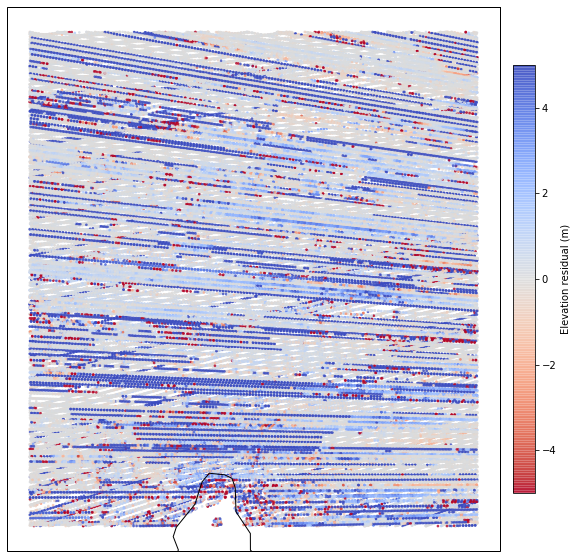

In [17]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::100], lat[::100], s=3, c=h_res[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
plt.clim([-5,5])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
ax.coastlines('50m')

Mean: -197171671.065 cm
Std.dev: 196272671654.706 cm
Rejected: 0.05 %


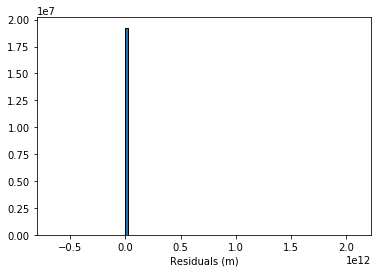

In [18]:
fig = plt.hist(h_res[~np.isnan(h_res)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')
print('Mean:', np.around(100*np.nanmean(h_res),3), 'cm')
print('Std.dev:',np.around(100*np.nanstd(h_res),3), 'cm')
print('Rejected:', np.around(100*(float(len(h_res[np.isnan(h_res)]))/len(h_res)),2), '%')

Well this looks noisy! Lets try to filter the data a bit using a global threshold of 10 m

In [19]:
h_res[np.abs(h_res) > 10] = np.nan

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Mean: 23.63 cm
Std.dev: 98.703 cm
Rejected: 8.07 %


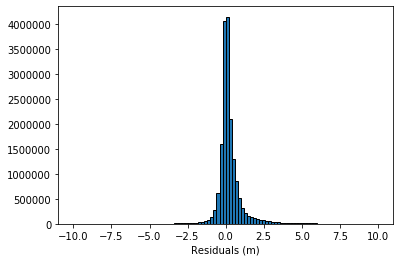

In [20]:
fig = plt.hist(h_res[~np.isnan(h_res)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')
print('Mean:', np.around(100*np.nanmean(h_res),3), 'cm')
print('Std.dev:',np.around(100*np.nanstd(h_res),3), 'cm')
print('Rejected:', np.around(100*(float(len(h_res[np.isnan(h_res)]))/len(h_res)),2), '%')

That is a lot better now we can clearly see a normal distribution around zero. But we can maybe do a bit better! Let's apply some outlier filtering that works in the spatial domain. For this we need to functions that are available in **utils.py**. The first one is **transform_coord** which allows us to move between different projection and is wrapper for pyproj.

In [21]:
x_i, y_i = transform_coord('4326', '3031', lon, lat)

Another fucntion in **utils** we now use is called **spatial_filter** which applies a robust n-sigma filter on the residuals inside a given domain. In this case 100 x 100 km with n=3.

In [22]:
z_i = spatial_filter(x_i, y_i, h_res.copy(), dx=100e3, dy=100e3, n_sigma=3)

/Users/nilssonj/Desktop/Altimetry/hackweek-2020/notebook/utils.py:369: RuntimeWarning: invalid value encountered in greater
  foo = np.abs(dh) > n_sigma * np.nanstd(dh)


In [23]:
print('Mean:', np.around(100*np.nanmean(z_i),3), 'cm/yr')
print('Std.dev:',np.around(100*np.nanstd(z_i),3), 'cm/yr')
print('Rejected:', np.around(100*(float(len(z_i[np.isnan(z_i)]))/len(z_i)),2), '%')

Mean: 18.466 cm/yr
Std.dev: 66.263 cm/yr
Rejected: 10.16 %


Text(0.5, 0, 'Residuals (m)')

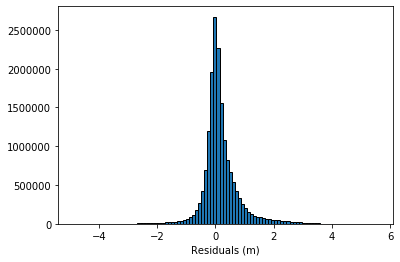

In [24]:
fig = plt.hist(z_i[~np.isnan(z_i)],100,edgecolor='k')
plt.xlabel('Residuals (m)')

That clearly helped a little bit to remove some more noise! Let us plot the residuals again to loook what changed!

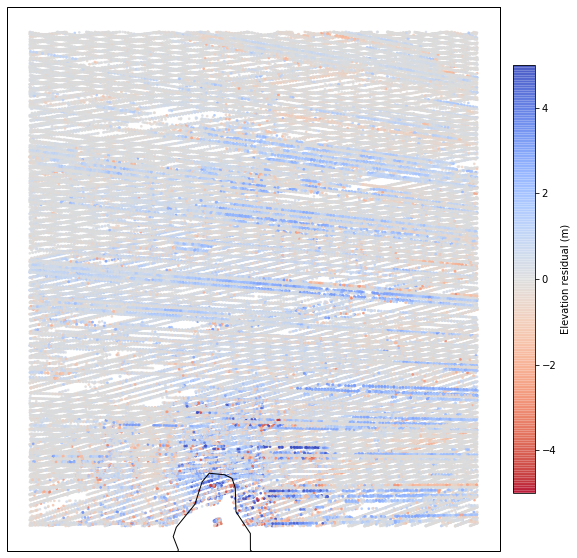

In [25]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::100], lat[::100], s=3, c=z_i[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
plt.clim([-5,5])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
ax.coastlines('50m')

The data now looks way more clear and we can even see some patterns, but not all the noise is gone but that's ok! Now let us investigate how the temporal variability looks like by plotting the residuals as a function of time. 

Text(0.5, 0, 'Time (yrs)')

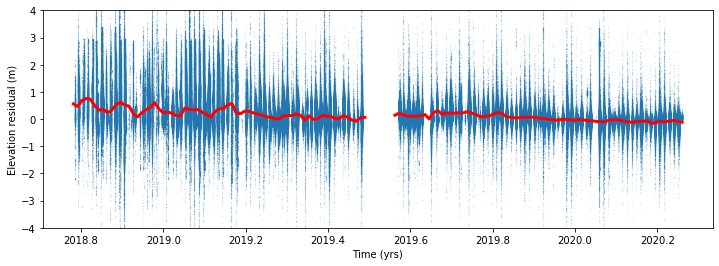

In [26]:
plt.figure(figsize=(12,4))
xb,yb = binning(t_yrs, z_i, xmin=2018.5,xmax=2020.26, dx=0.125 / 12., window=0.25 / 12., median=True)[0:2]
plt.plot(t_yrs[::10],z_i[::10],'.',markersize=0.1)
plt.plot(xb, yb,'-r', linewidth=3)
plt.ylim([-4,4])
plt.ylabel('Elevation residual (m)')
plt.xlabel('Time (yrs)')

There is a trend here! PIG has been loosing elevation for the last 1.5 years!

In [27]:
p = np.polyfit(t_yrs[~np.isnan(z_i)],z_i[~np.isnan(z_i)],1)
print('Trend:',np.around(p[0],2),'(m/yr)')

Trend: -0.47 (m/yr)


## Spatio-temporal interpolation
Ok we now have tons of data here! Remember ICESat-2 ATL06 product has an along-track sampling of 20 m, so we need to reduce this data into workable format for further analysis. One way of doing this is to interpolate the data to a regular grid with a specific resolution. In our tutorial we are going to do this in both space and time to create monthly time series in the form of a data cube. A simple program for this purpose is **interpgaus3d.py** available in captoolkit (there is many more that work both in 2d and 3d). This is a simple 3D (or you might want to call it 4D) interpolator using a gaussian kernel in both space and time to compute a value at each grid node.

**Later in the tutorial we are going to discuss different interpolation techniques in more detail**

Let have a look at the program and its input!

In [28]:
!python ./interpgaus3d.py -h

usage: interpgaus3d.py [-h] [-b w e s n] [-d dx dy] [-t tmin tmax dt]
                       [-r radius] [-a alpha_d alpha_t] [-p epsg_num]
                       [-s n_sample] [-c dim thres max] [-v x y z t s]
                       ifile [ifile ...] ofile [ofile ...]

Spatio-temporal interpolation of irregular data

positional arguments:
  ifile               name of input file (h5-format)
  ofile               name of ouput file (h5-format)

optional arguments:
  -h, --help          show this help message and exit
  -b w e s n          bounding box for geograph. region (deg or m), optional
  -d dx dy            spatial resolution for grid (deg or km)
  -t tmin tmax dt     temporal resolution for grid (months)
  -r radius           search radius (km)
  -a alpha_d alpha_t  spatial and temporal corr. length (km and months)
  -p epsg_num         EPSG proj number (AnIS=3031, GrIS=3413)
  -s n_sample         sample every n:th point in dataset
  -c dim thres max    dim. of filter in km, si

In [43]:
!python ./interpgaus3d.py ./IS2_HEIGHTS_PIG_AD.h5 ./data_cube.h5 -d 5 5 -t 2018.8 2020.25 0.25 \
-r 30 -a 10 0.25 -p 3031 -c 100 3 10 -v lon lat h_res t_year dummy -s 100

parameters:
('ifile', ['./IS2_HEIGHTS_PIG_AD.h5'])
('ofile', ['./data_cube.h5'])
('bbox', [None])
('dxy', [5.0, 5.0])
('time', [2018.8, 2020.25, 0.25])
('radius', [30.0])
('alpha', [10.0, 0.25])
('proj', ['3031'])
('n_sample', [100])
('filter', [100.0, 3.0, 10.0])
('vnames', ['lon', 'lat', 'h_res', 't_year', 'dummy'])
-> reading data ...
-> cleaning data ...
-> creating kdtree ...
-> interpolating data ...
-> saving predictions to file...


Now let us have a look at the simple structure of the data using **h5ls**.

In [44]:
!h5ls data_cube.h5

X                        Dataset {64, 58}
Y                        Dataset {64, 58}
Z_nobs                   Dataset {71, 64, 58}
Z_pred                   Dataset {71, 64, 58}
Z_rmse                   Dataset {71, 64, 58}
epsg                     Dataset {SCALAR}
time                     Dataset {71}


Data are saved as arrays and vectors: **Z_pred** = gridded values, **Z_rmse** = the error for each value and **Z_nobs** = number of points in solution.

In [45]:
with h5py.File('./data_cube.h5','r') as f_c:
    Xi = f_c['X'][:]
    Yi = f_c['Y'][:]
    ti = f_c['time'][:]
    Zi = f_c['Z_pred'][:]

Interpolate our mask to the extent of our prediction grid using **interp2d** using the nearest point (order=0 and for bilinear order=1).

In [46]:
Zmi = interp2d(Xm, Ym, Zm, Xi.ravel(), Yi.ravel(), order=0).reshape(Xi.shape)

In [47]:
Lon, Lat = transform_coord('3031','4326', Xi, Yi)

Apply the mask to our datacube

In [48]:
Zi[:, Zmi == 0] = np.nan

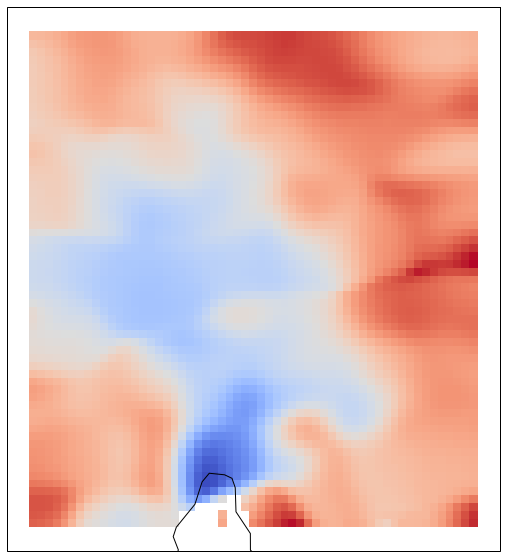

In [49]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.pcolormesh(Lon, Lat, Zi[25,::], transform=ccrs.PlateCarree(), cmap='coolwarm_r')
ax.coastlines('50m')

Quick way of constructing a ROI time series of the cube

In [50]:
hi = np.nanmean(np.nanmean(Zi,1),1)

Interpolated time series: -0.44
Linear fit to data: -0.47


Text(0, 0.5, 'Elevation residuals (m)')

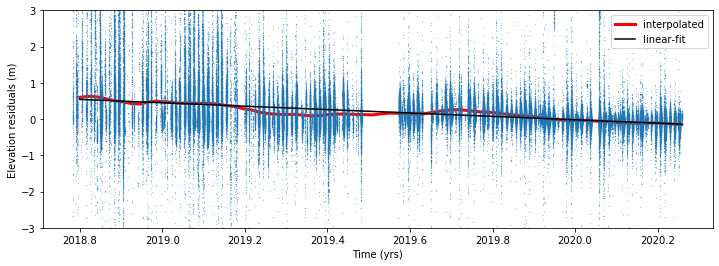

In [51]:
plt.figure(figsize=(12,4))
plt.plot(ti, hi,'r',linewidth=3,label='interpolated')
plt.plot(t_yrs[::100], h_res[::100], '.', markersize=0.3,linewidth=3)
p1 = np.polyfit(ti[~np.isnan(hi)], hi[~np.isnan(hi)],1)
p2 = np.polyfit(t_yrs[~np.isnan(z_i)], z_i[~np.isnan(z_i)],1)
plt.plot(ti, np.polyval(p2, ti),'k',label='linear-fit')
plt.legend()
print('Interpolated time series:',np.around(p1[0],2))
print('Linear fit to data:',np.around(p2[0],2))
plt.ylim([-3,3])
plt.xlabel('Time (yrs)')
plt.ylabel('Elevation residuals (m)')

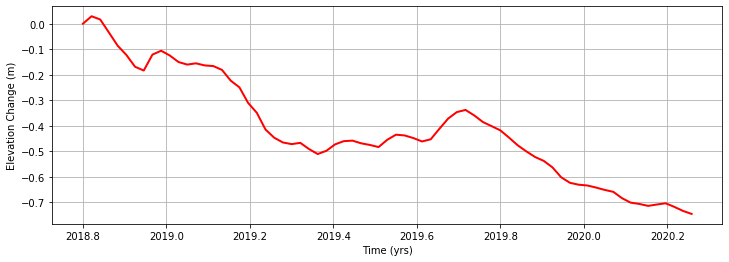

In [52]:
plt.figure(figsize=(12,4))
plt.plot(ti, hi - hi[0],'r',linewidth=2)
plt.ylabel('Elevation Change (m)')
plt.xlabel('Time (yrs)')
plt.grid()

Ok we checked overall time series what about the spatial pattern of elevation change? We can get that by fitting a linear rate to each grid-cell.

In [53]:
nt,nx,ny = Zi.shape
rate = np.zeros((nx,ny))*np.nan
for i in range(nx):
    for j in range(ny):
        dh = Zi[:,i,j]
        if np.any(np.isnan(dh)):continue
        rate[i,j] = np.polyfit(ti,Zi[:,i,j],1)[0]

Ones we estimated the rate let's apply some gentle smoothing using a mean filter kernel. You can use any function here if you want! Also, lets use the mask that we read in before to mask out unwanted areas.

In [54]:
Zf = generic_filter(rate.copy(), np.nanmean, 3)
Zf[Zmi == 0] = np.nan

Trend: -0.44 (m/yr)


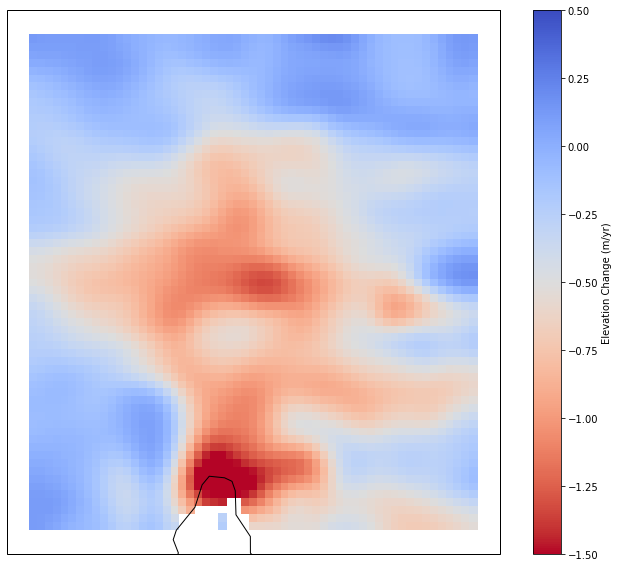

In [55]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
im = plt.pcolormesh(Lon, Lat, Zf, transform=ccrs.PlateCarree(), cmap='coolwarm_r',vmin=-1.5,vmax=0.5)
ax.coastlines('50m')
plt.colorbar(label='Elevation Change (m/yr)')
print('Trend:',np.around(np.nanmean(Zf),2),'(m/yr)')

In [59]:
dVdt = np.nansum(Zf)*5e3*5e3*1e-9
print('Volume Change:',np.around(dVdt,1),'(km3/yr)')

Volume Change: -40.6 (km3/yr)


That's it! From just a few lines of code we can create a dataset that allows us to estimate the draw-down pattern using ICESat-2 for PIG for both space and time.   

## Constructing a digital elevation model

From **fittopo.py** we also have the mean surface height from all our solutions and which are now referenced to the same common time 2020. So, let’s go through a few steps to show how we can obtain a DEM in a relatively easy manner.

In [60]:
h_h = h_mod.copy()

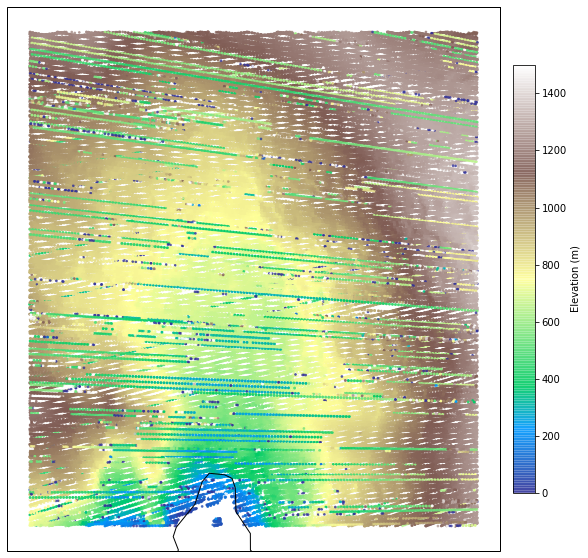

In [61]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::100], lat[::100], s=3, c=h_h[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
plt.clim([0,1500])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

First, let us remove the bad data that we identified in residual filtering!

In [62]:
h_h[np.isnan(z_i)] = np.nan

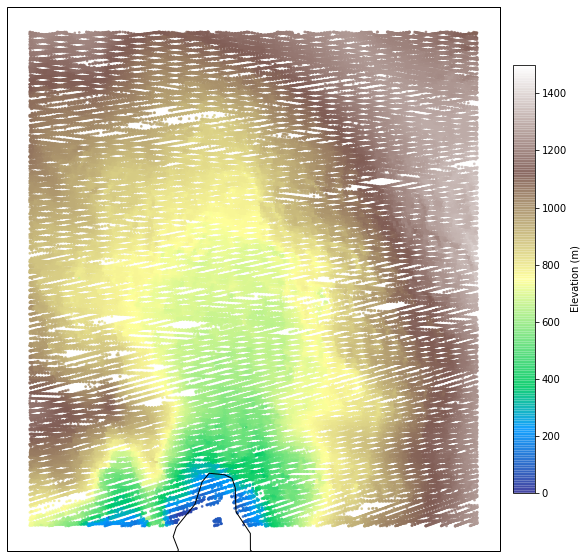

In [63]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::100], lat[::100], s=3, c=h_h[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
plt.clim([0,1500])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

In [64]:
x_h, y_h = transform_coord('4326', '3031', lon, lat)

Construct a grid for the DEM with a 1 km resolution using **make_grid** function or any other way you wish.

In [65]:
Xdem, Ydem = make_grid(x_h.min(), x_h.max(), y_h.min(), y_h.max(), 1e3, 1e3)

Interpolate our grounded ice mask to our DEM-grid using bilinear interpoaltion (order=1). 

In [66]:
Zm_i = interp2d(Xm, Ym, Zm, Xdem.ravel(), Ydem.ravel(), order=1).reshape(Xdem.shape)

These interpolators are avaliable in **utils.py** and are simplfied versions of stand-alone programs that can be used for data analysis inside notebooks etc.

In [67]:
from utils import interpkrig, interpmed, interpgaus

Identify and remove any NaN's in the data 

In [68]:
i_nan = ~np.isnan(h_h)

# Some notes on interpolation algorithms 

There are many different types of interpolation functions, which all have pros and cons, and some are more appropriate than others to specific problems. One thing to note is if you have very dense datasets with good point density and coverage there will usually be very little difference in the interpolated results from the different algorithms. One should note that to obtain good results data should be relatively clean and free of outliers!

**Some common interpolation algorithm**
- ***Kriging/Collocation (interpkrig):***\
Least-Squares Collocation (LSC), mostly known as Kriging, is a geostatistical method of spatial interpolation modeled by a gaussian process governed by the data covariance. In general the LSC method is better at preserving spatial detail and variability than other simpler distance-based interpolation methods, if the spatial auto-correlation of the data is substantial. LSC, also generates estimates of uncertainty for each prediction and also allows for error-propagation via the covariance structure.
- ***Gaussian Weighed Average (interpgaus):***\
One of the most common interpolation approaches to interpolate irregular scattered data onto a regular grid using a weighted average, with a gaussian weighing function based on distance away from the prediction point. This interpolation approach provides a smooth continuous surface constrained by the range of the data. However, the weighted average is sensitive to large outliers and the data distribution, the same as for the median.
- ***Median (interpmed):***\
Using the median for spatial interpolation has some advantages, as it is less sensitive to outliers in the data, and thus provide very clean and nice-looking grids. However, for producing volume change estimates for large regions (continental) it is less useful. This is because, as we could see in the histogram, we usually have a negative skewed distributions of elevation change. Thus, using the median we will estimates value will be biased in the positive direction. Further, the usage of the median does not allow us to incorporate far-field data, as no weighting for distance is possible.

In [69]:
z_dem = interpkrig(x_h[i_nan][::100], y_h[i_nan][::100], h_h[i_nan][::100].copy(),\
                   np.ones(h_h[i_nan][::100].shape)*1, Xdem, Ydem, n=20, d=20e3, a=5e3)[0]
"""
z_dem = interpgaus(x_h[i_nan][::100], y_h[i_nan][::100], h_h[i_nan][::100].copy(),\
                  np.ones(h_h[i_nan][::100].shape)*1, Xdem, Ydem, n=20, d=20e3, a=5e3)[0]
                  
z_dem = interpmed(x_h[i_nan][::100], y_h[i_nan][::100], h_h[i_nan][::100].copy(), Xdem, Ydem, n=20, d=20e3)
"""

'\nz_dem = interpgaus(x_h[i_nan][::100], y_h[i_nan][::100], h_h[i_nan][::100].copy(),                  np.ones(h_h[i_nan][::100].shape)*1, Xdem, Ydem, n=20, d=20e3, a=5e3)[0]\n                  \nz_dem = interpmed(x_h[i_nan][::100], y_h[i_nan][::100], h_h[i_nan][::100].copy(), Xdem, Ydem, n=20, d=20e3)\n'

The output of the functions are 1D-arrays, as you might want to interpolate points data as well (flight-tracks etc), so it needs to be changed back to a grid.

In [70]:
Z_dem = z_dem.reshape(Xdem.shape)

Apply the mask to the grid

In [71]:
Z_dem[Zm_i == 0] = np.nan

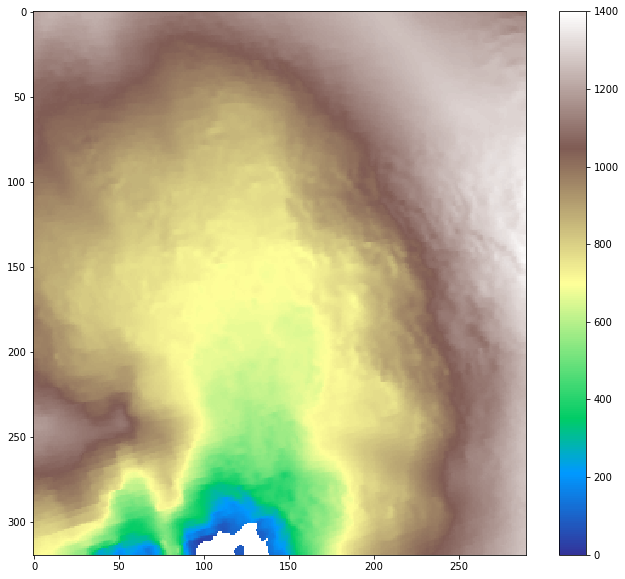

In [72]:
fig = plt.figure(figsize=(12,10))
plt.imshow(np.flipud(Z_dem), cmap='terrain', vmin=0, vmax=1400)
plt.colorbar()

## Quality assesment using crossover analysis

One of the most widely used methods to study elevation change using altimetry data is the **"crossover"** method. It is the most robust and accurate method currently available. It can be used for both deriving elevation change and to study the precision of the measurements themselves.

![crossover_method.png](crossover_method.png "Figure of Eleavtion Change from ICESat")


From this method the surface elevation change is estimated at the intersection of two sub-satellite ground tracks at different times. At this crossover location the two closest points in each track is used to interpolate both elevation and time to the crossover location, allowing us to compute $\delta h/\delta t$ = $H_{t_{2}}-H_{t_{1}}$. [Image credit Zwally et al. (1989)]

**"captoolkit"** has a program called **xover.py** to compute satellite/airborne crossover differences! Let us look at the input to the program!

In [73]:
!python xover.py -h

usage: xover.py [-h] [-o ofile] [-r radius] [-p epsg_num] [-d tile_size]
                [-k na nd] [-b buffer] [-m {linear,cubic}]
                [-v o x y t h b l t] [-t t1 t2] [-f] [-q] [-i]
                ifile ifile

Program for computing satellite/airborne crossovers.

positional arguments:
  ifile               name of two input files to cross (HDF5)

optional arguments:
  -h, --help          show this help message and exit
  -o ofile            name of output file (HDF5)
  -r radius           maximum interpolation distance from crossing (m)
  -p epsg_num         projection: EPSG number (AnIS=3031, GrIS=3413)
  -d tile_size        tile size (km)
  -k na nd            along-track sample every n:th pnt for each file
  -b buffer           tile buffer (km)
  -m {linear,cubic}   interpolation method, "linear" or "cubic"
  -v o x y t h b l t  main vars: names if HDF5,
                      orbit/lon/lat/time/height/bs/lew/tes
  -t t1 t2            only compute crossovers for given t

In [74]:
!python ./xover.py ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5 ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_D.h5 \
-o ./xovers.h5 -r 100 -p 3031 -d 10 -k 20 20 -m linear -v orbit lon lat t_year h_elv dum dum dum

parameters:
('input', ['./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5', './tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_D.h5'])
('output', ['./xovers.h5'])
('radius', [100.0])
('proj', ['3031'])
('dxy', [10])
('nres', [20, 20])
('buff', [0])
('mode', ['linear'])
('vnames', ['orbit', 'lon', 'lat', 't_year', 'h_elv', 'dum', 'dum', 'dum'])
('tspan', [None, None])
('tile', False)
('plot', False)
('diff', False)
crossing files: ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_A.h5 ./tutorial-data/gridding-time-series/org/IS2_HEIGHTS_PIG_D.h5 ...
tileing asc/des data...
computing crossovers ...

execution time: 0:02:51.270027
number of crossovers found: 94590
statistics -> mean: 0.01 std.dev: 0.115 (m) (dt<30d)
statistics -> mean: -0.37 std.dev: 0.88 (dvar/yr)
ofile name -> ./xovers.h5


In [75]:
!h5ls ./tutorial-data/gridding-time-series/proc/xovers.h5

dh_elv                   Dataset {94590}
dhdt                     Dataset {94590}
dt_year                  Dataset {94590}
h_elv_1                  Dataset {94590}
h_elv_2                  Dataset {94590}
lat                      Dataset {94590}
lon                      Dataset {94590}
orbit_1                  Dataset {94590}
orbit_2                  Dataset {94590}
t_year_1                 Dataset {94590}
t_year_2                 Dataset {94590}


In [76]:
with h5py.File('./tutorial-data/gridding-time-series/proc/xovers.h5','r') as f_xo:
    lon_xo = f_xo['lon'][:]
    lat_xo = f_xo['lat'][:]
    dh_xo  = f_xo['dh_elv'][:]
    dt_xo  = f_xo['dt_year'][:]

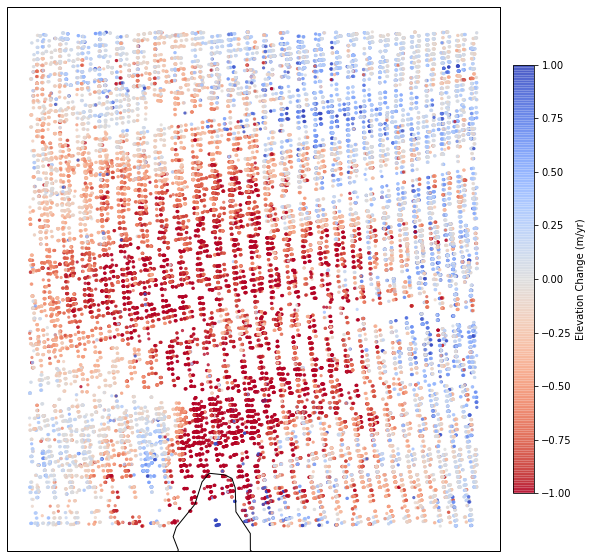

In [77]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon_xo[np.abs(dt_xo)>6./12], lat_xo[np.abs(dt_xo)>6./12], s=5,\
            c=dh_xo[np.abs(dt_xo)>6./12]/dt_xo[np.abs(dt_xo)>6./12], \
            alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')

In [78]:
x_xo, y_xo = transform_coord('4326','3031',lon_xo, lat_xo)

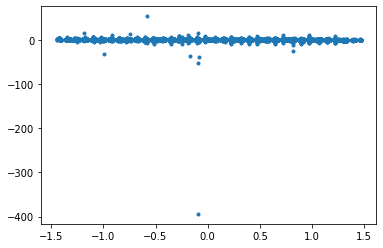

In [79]:
plt.plot(dt_xo, dh_xo,'.')

Trend: -0.37 (m/yr)


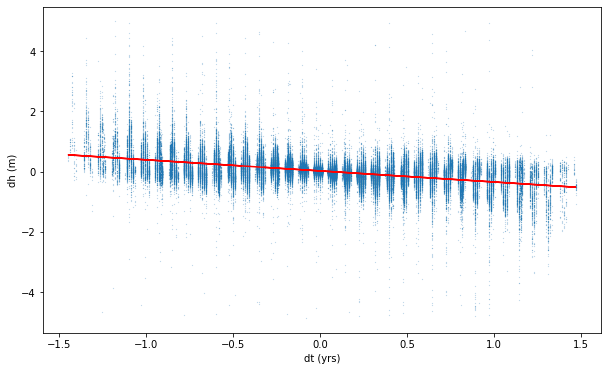

In [80]:
plt.figure(figsize=(10,6))
plt.plot(dt_xo[np.abs(dh_xo)<5],dh_xo[np.abs(dh_xo)<5],'.',markersize=0.2)
c_fit = np.polyfit(dt_xo[np.abs(dh_xo)<5], dh_xo[np.abs(dh_xo)<5], 1)
plt.plot(dt_xo[np.abs(dh_xo)<5], np.polyval(c_fit, dt_xo[np.abs(dh_xo)<5]),'r')
plt.ylabel('dh (m)')
plt.xlabel('dt (yrs)')
print('Trend:',np.around(c_fit[0],2),'(m/yr)')

For the quality assesment lets only use height differences of < 5 meters and time differences < 30 days.

In [81]:
i_keep = (np.abs(dh_xo) < 5) & (np.abs(dt_xo) < 1./12)

In [82]:
x_xo, y_xo, dt, dh = x_xo[i_keep], y_xo[i_keep], dt_xo[i_keep], dh_xo[i_keep] 

Text(0, 0.5, 'Frequency')

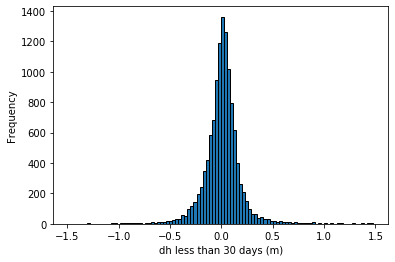

In [83]:
fig = plt.hist(dh[np.abs(dh) < 1.5], 100,edgecolor='k')
plt.xlabel('dh less than 30 days (m)')
plt.ylabel('Frequency')

In [84]:
print('A/D-Bias:',np.around(np.nanmedian(dh)*100,2), 'cm')
print('Error:',np.around(mad_std(dh)*100,2), 'cm')

A/D-Bias: 1.01 cm
Error: 11.52 cm


Let's read some surface slope data

In [85]:
Xs, Ys, Zs = tiffread('./tutorial-data/gridding-time-series/REMA_1km_slope_filled_deg.tif')[0:3]

Interpolate slope values from raster to crossovers

In [86]:
slope = interp2d(Xs, Ys, Zs, x_xo, y_xo, order=1)

Bin data as a function of surface slope and output some statistics!

In [87]:
slp_b, bias_b, error_b = binning(slope, dh, xmin=0,xmax=1, dx=0.025, window=0.025)[0:3]

Text(0.5, 0, 'Slope (deg)')

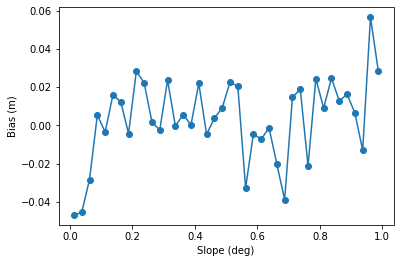

In [88]:
plt.plot(slp_b, bias_b, '-o')
plt.ylabel('Bias (m)')
plt.xlabel('Slope (deg)')

Text(0.5, 0, 'Slope (deg)')

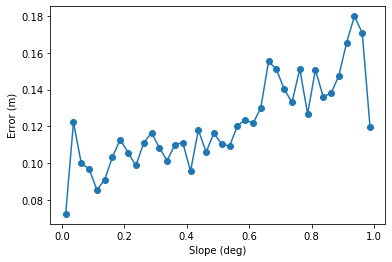

In [89]:
plt.plot(slp_b, error_b, '-o')
plt.ylabel('Error (m)')
plt.xlabel('Slope (deg)')

In [90]:
np.around([slope.min(), slope.max(), slope.mean()],2)

array([0.02, 3.77, 0.42], dtype=float32)

# Some homework maybe?

If there is enough time let us breakout in different groups and try to work with the data in different ways:

Try to play around with different parameters and see how they impact your results.
- Search radius, grid resolution and model selection etc. in "fittopo.py".
- Spatio-temporal resolution and correlation lengths in "intergaus3d.py".
- Change the thresholds for the global and regional outlier editing